In [56]:
import pickle, os, time, string
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## 여기는 식당 관점에서 바라보는 통계를 뽑아 대시보드에 넣는 걸 목표로 하는 코드

##### User_review handling.ipynb에서는 유저의 관점에서의 통계 및 클러스터링 뽑아내는 것

In [8]:
with open('category_naver_map.pkl', 'rb') as g:
    category_naver = pickle.load(g)

In [3]:
with open('naver_ppd_2.pkl', 'rb') as f:
    mvp_long = pickle.load(f)

In [4]:
review_num = 0
no_review_obj = []
no_review_title = []
no_review_category = []
for i in tqdm(range(len(mvp_long))):
    try:
        review_num += len(mvp_long[i]['review'])
    except:
        no_review_obj.append(mvp_long[i]['obj_key'])
        no_review_title.append(mvp_long[i]['title'])
        no_review_category.append(mvp_long[i]['category'])

  0%|          | 0/128578 [00:00<?, ?it/s]

In [5]:
print(len(no_review_obj), len(no_review_category), len(no_review_title), review_num)

15685 15685 15685 19274978


In [5]:
def review_dt(data, basic_info):
    entire_review = []
    for x in data:
        ith_review = x.split('\n')
        if ith_review[0]=='별점' or len(ith_review)==1 :  # 이 경우 닉네임이 없음. 아마도 탈퇴회원이지 않을까 싶음. 이런 경우가 얼마나 더 있는지 새로운 데이터로 확인 필요
            continue          # len( )==1인 경우는 방문일이 없는 경우 or 검열에 걸려서 삭제된 리뷰
        try:
            if ith_review[0]=='이미지':  # 이미지 준비중이라고 긁힌 게 있음
                ith_review = ith_review[2:]
            user_name = ith_review[0]
        except:
            print(ith_review)
            continue
        value_dict = {}
        value_dict['obj_key'] = basic_info['obj_key']
        value_dict['title'] = basic_info['title']
        value_dict['주차'] = basic_info['주차']
        value_dict['category'] = basic_info['category']
        value_dict['loc'] = basic_info['loc']
        value_dict['user_name'] = user_name
        
        num_details = ith_review[1].split(' ')
        if len(num_details) ==1:   # 리뷰, 사진, 팔로워를 못 긁은 경우
            review_num = 0
            photo_num = 0
            follower_num = 0
        elif len(num_details) == 2:
            review_num = num_details[1]
            photo_num = 0
            follower_num = 0
        elif len(num_details)==3:
            if num_details[1].endswith('사진'):
                review_num = num_details[1][:-2]
                photo_num = num_details[2]
                follower_num = 0
            elif num_details[1].endswith('팔로워'):
                review_num = num_details[1][:-3]
                photo_num = 0
                follower_num = num_details[2]
        elif len(num_details)==4:
            review_num = num_details[1][:-2]
            photo_num = num_details[2][:-3]
            follower_num = num_details[3]
        try:
            review_num = str(review_num)   ####### user_key가 달라도 nickname이 똑같은데 num_details가 비슷하면 같은 유저로 취급해주는 로직 추가해야함. 
            photo_num = str(photo_num)     # 가장 쉬운 방법은 combination으로 검증하는건데 90만개라서 연산량이 상당할듯
            follower_num = str(follower_num)
        except:
            print(value_dict)
            print(ith_review)
            continue

        user_dict_name =user_name + '!@#$'+ review_num + '!@#$' + photo_num + '!@#$' + follower_num
        value_dict['user_id'] = user_dict_name
        
        follow_str_ind = np.where(np.array(ith_review)=='팔로우')[0]
        visit_date_ind = np.where(np.array(ith_review)=='방문일')[0]
        if len(visit_date_ind)==0:  
            pass
        else:
            try:
                value_dict['date_calendar'] = ith_review[visit_date_ind[0]+1] 
                date_kor = ith_review[visit_date_ind[0]+2][:-4]
                if date_kor[4]=='년':
                    value_dict['date_kor'] = pd.to_datetime(date_kor, format='%Y년 %m월 %d일')
                else:
                    value_dict['date_kor'] = pd.to_datetime('1999년 2월 1일', format='%Y년 %m월 %d일')
                value_dict['visit_num']= int(ith_review[visit_date_ind[0]+3][0])
                review_body = ith_review[follow_str_ind[0]+1:visit_date_ind[0]]
                check1, check2=True, True
                while check1:
                    if len(review_body)==0:
                        break
                    if review_body[0]=='방문자리뷰':
                        review_body.pop(0)
                    else:
                        check1=False
                while check2:
                    if len(review_body)==0:
                        break
                    if (review_body[-1]=='반응 남기기')or(review_body[-1]=='표정을 눌러 반응을 남겨 보세요!'):
                        review_body.pop(-1)
                    else:
                        check2=False
                if len(review_body)==0:
                    continue
                else:
                    if review_body[0]=='별점':
                        review_body = review_body[3:]
                value_dict['review']= ' '.join(review_body)
            except:
                continue
        entire_review.append(value_dict)
    return pd.DataFrame(entire_review)

In [50]:
basic_info = {}
each_review = pd.DataFrame()
for_concat = []
for each in tqdm(mvp_long):
    try:
        basic_info['obj_key'] = each['obj_key']
        basic_info['title'] = each['title']
        if '주차' in ' '.join(each['info']):
            basic_info['주차'] = True
        else:
            basic_info['주차'] = False
        basic_info['category'] = each['category']
        basic_info['loc'] = each['loc']
        for_concat.append(review_dt(each['review'], basic_info))
    except:
        continue
each_review = pd.concat(for_concat, ignore_index=True)
each_review.reset_index(inplace=True)
each_review.drop('index', inplace=True, axis=1)
each_review.set_index(each_review['date_kor'], inplace=True)

  0%|          | 0/128578 [00:00<?, ?it/s]

{'obj_key': 'gc3BpFVy4BMynGmI', 'title': '이디야커피 광산사거리점', '주차': False, 'category': '카페', 'loc': '서울 강북구 수유동', 'user_name': '몽냥이네강아지분양'}
['몽냥이네강아지분양', '리뷰 5테마 1', '팔로우', '기분좋은아침으로 시작할 수 있었습니다\U0001fa77', '계산부터 응대까지 여사장님 너무 친절하세요ㅠㅠ', '단순히 커피만 내려주실 수 있는건데도 ', '맛잇게드세요~! 라는 활기찬 말 한마디도 ', '너무 기분 좋았습니다💪🏻 번창하시구 광산사거리 올때 꼭 다시 들리겠습니당 ㅎㅎㅎㅎ', '친절해요매장이 청결해요좌석이 편해요커피가 맛있어요음료가 맛있어요', '반응 남기기', '방문일', '7.12.수', '2023년 7월 12일 수요일', '1번째 방문', '인증 수단', '영수증', '이디야커피 광산사거리점', '7.14.금', '2023년 7월 14일 금요일', '고객님~ 정성 어린 후기 너무 감사드립니다~^^ 고객님 글 덕분에 아침부터 기분 업으로 시작하게 됐네요 ㅎ 칭찬은 고래도 춤추게 한다더니 울 고객님께서 의욕과 힘을 주셨어요~^^ 다시 한번 감사드리며 이쪽 오시면 꼭 또 뵈어요~~^^💗💗💗']
{'obj_key': 'qeSEPjSjt7GurA9Z', 'title': '횟집좋을', '주차': False, 'category': '생선회', 'loc': '서울 중구 필동2가', 'user_name': 'kmsoojin'}
['kmsoojin', '리뷰 10테마 1', '팔로우', '지인 모임으로 특선코스 먹었는데 넘넘 잘 나와서 모두 대만족~~^^', '친절해요주차하기 편해요특별한 메뉴가 있어요재료가 신선해요가성비가 좋아요', '반응 남기기', '방문일', '8.25.금', '2023년 8월 25일 금요일', '2번째 방문', '인증 수단', '영수증']


In [51]:
with open('./each_review.pkl', 'wb') as f:
    pickle.dump(each_review, f)

In [170]:
part_each_review = each_review.loc['2022-08-01':]

In [171]:
part_each_review.shape

(9495801, 11)

In [58]:
# with open('dashboard_each_review.pkl', 'wb') as f:
#     pickle.dump(part_each_review, f)

with open('dashboard_each_review.pkl', 'rb') as f:
    part_each_review = pickle.load(f)

In [477]:
# recent = part_each_review.loc['2023-03-01':'2023-04-30']
# recent = part_each_review.loc['2023-05-01':'2023-06-30']
recent = part_each_review.loc['2023-07-01':'2023-08-31']

### 리뷰 이벤트 검사 - 리뷰 많은 순으로 정렬

In [471]:
import collections
target = [x[0] for x in collections.Counter(recent['title']).most_common()[325:350]]

In [478]:
collections.Counter(recent['title']).most_common()[:30]

[('카츠공방 남부터미널점', 1842),
 ('은행골 강남역점', 1621),
 ('백소정 교대점', 1511),
 ('감동식당', 1348),
 ('수아당', 1332),
 ('스시도쿠 왕십리본점', 1272),
 ('한과미의식 안녕인사동점_3', 1249),
 ('카츠공방 내방역점', 1248),
 ('백소정 고덕역점', 1199),
 ('투파인드피터 서울홍대점', 1184),
 ('백소정 매봉점', 1165),
 ('백소정 신림점', 1143),
 ('카츠공방 교대점', 1108),
 ('고수닭갈비', 1043),
 ('끄네들로', 1032),
 ('마운틴누크 송리단길점', 984),
 ('타코튜즈데이 성수 본점', 958),
 ('백소정 건대본점', 956),
 ('은행골 신사점', 953),
 ('백소정 세곡점', 953),
 ('스타벅스 한국프레스센터점', 948),
 ('백소정 까치산역점', 927),
 ('파차마마 베이커리', 922),
 ('필앳홈', 848),
 ('일미락 목동본점', 820),
 ('하우에버 연남', 820),
 ('코리코카페', 802),
 ('빌라 더 다이닝', 800),
 ('상암일미락', 790),
 ('스타벅스커피코리아', 787)]

In [466]:
for x in zip(target, [x[0] for x in collections.Counter(recent['obj_key']).most_common()[:25]]):
    print(x)

('백소정 이수역점', 'zYJ5cV9OKKuRSOY0')
('더식당', 'KZ21y9mL5dNPuKtP')
('호랑이도삭면 종로점', '1S6JXNGU0F8vyVjn')
('88로타리집 홍대점', 'jC6gcJwjDKese6u3')
('백소정 위례점', 'xURACGYgsQTDDVWW')
('백소정 아차산역점', 'XNiqYXQNeGjbwl5B')
('돼슐랭 마곡나루점', 'eMEuOgKBUy4BSJWL')
('치플레', 'VPtE4L1HDGibaZEy')
('엠브로돈까스 건대점', 'W894jdYDXXuVYJRS')
('베니케이크', '4myuDN7wNNWnrQ1a')
('대포찜닭', '623lWUWJ1Psl0TEl')
('긴자료코 건대점', '2I9gdQeSEXiPOpVE')
('샤오바오우육면 여의도점', '34Q1bMbNwcsofxnN')
('우월소곱창 마포직영점', 'bGvvZ2ynjdxd6n7f')
('백소정 대학로점', 'TgmWbWjhQoblRyyG')
('해머플레이스', 'anMFap3AyjyvJbdr')
('냅다청양집 상암직영점', 'ME1vm6dzwDPM7Kbp')
('백소정 신촌점', 'NuKQeuMjbAPvauNa')
('금성회관 합정본점', 'KsGPoYi4d4Zz1BMR')
('사생활', 'eKox00hO6xz2SW7p')
('백소정 경희대점', 'A4vjp1R7qYSbvwV7')
('백소정 양천구청점', 'zE0i9mVRw2gR1wXr')
('초이다이닝 송파점', 'C7tu8yflUvekVR71')
('츠케루', '6xVPwzoqzQnTARMa')
('백소정 노원중앙점', 'Sq3KOvw3EtgA5hx6')


In [468]:
for x in mvp_long:
    if x['obj_key'] in '6xVPwzoqzQnTARMa':
        print(x['title'], x['review_num'])

스시도쿠카미동 왕십리본점 ['방문자리뷰 4,916', '블로그리뷰 563']


In [470]:

obj = [x[0] for x in collections.Counter(recent['obj_key']).most_common()[325:350]]
for x in mvp_long:
    if x['obj_key'] in obj:
        print(x['title'])
        l = len(x['review_num'])
        for i in range(l):
            if x['review_num'][i].startswith('방문자'):
                visit_num = int(x['review_num'][i].split(' ')[1].replace(',', ''))
            elif x['review_num'][i].startswith('블로그'):
                blog_num = int(x['review_num'][i].split(' ')[1].replace(',', ''))
#             else:
#                 print(x['review_num'][i])
print(visit_num/blog_num)

골목길닭꼬치
성북동빵공장
페르시안궁전
오봉집 종로점
광화문미진
오마이샬롬
던킨 시청역점
구욱희씨 서울숲 본점
탕화쿵푸 숙대점
일품한우 마곡본점
전설의우대갈비 서울상암직영점
버거킹 노원역점
타이펀트
맥도날드 대학로점
대성성
명륜진사갈비 서울신촌점
빌라드코스테스
수잔나의 앞치마
명륜진사갈비 영등포 신길점
김창훈포차
롯데리아 신김포공항점
스타벅스 별다방점
놀부주방 반포점
담산 잠실새내점
마복림떡볶이_3
2.6790415119811004


In [264]:
import collections
collections.Counter(recent['title']).most_common()

[('백소정 방배역점', 1280),
 ('백소정 동국대점', 968),
 ('서촌금상고로케', 917),
 ('백소정 강남직영점', 862),
 ('스시도쿠 더성수', 859),
 ('백소정 은행사거리점', 829),
 ('백소정 신림점', 812),
 ('더식당', 787),
 ('초이다이닝 성수점', 772),
 ('코코이찌방야 롯데몰김포공항점', 755),
 ('백소정 건대본점', 753),
 ('대포찜닭', 740),
 ('백소정 연신내점', 739),
 ('스시로로', 739),
 ('에그서울', 735),
 ('투파인드피터 노원점', 720),
 ('백소정 까치산역점', 716),
 ('오공김밥 봉천점', 716),
 ('엠브로돈까스 건대점', 709),
 ('고수닭갈비', 686),
 ('투파인드피터 서울홍대점', 679),
 ('금성회관 서울시청직영점', 673),
 ('백소정 위례점', 670),
 ('제임스키친', 670),
 ('일미락 목동본점', 650),
 ('빌라 더 다이닝', 649),
 ('긴자료코 건대점', 649),
 ('끄네들로', 648),
 ('팔각도 연신내역점', 648),
 ('군산오징어 당산역점', 639),
 ('백소정 고덕역점', 639),
 ('오공김밥 등촌점', 631),
 ('알부자', 629),
 ('밀탄', 629),
 ('위샐러듀 프레쉬', 628),
 ('백소정 서울대입구역점', 624),
 ('서울숲포도피자 성수_4', 623),
 ('백소정 아차산역점', 622),
 ('백소정 양천구청점', 613),
 ('쉘리', 612),
 ('진작다이닝', 610),
 ('백소정 등촌역점', 609),
 ('후타츠', 606),
 ('버섯잔치집 본점', 604),
 ('탐라도야지', 602),
 ('타르데마베이커리 방화본점', 601),
 ('마운틴누크 송리단길점', 597),
 ('금성회관 목동점', 590),
 ('사발떡볶이', 590),
 ('초이다이닝 송파점', 589),
 ('을지정밀', 588),

In [232]:
import collections
collections.Counter(recent['title']).most_common()

[('카츠공방 남부터미널점', 1805),
 ('은행골 강남역점', 1578),
 ('백소정 교대점', 1488),
 ('감동식당', 1310),
 ('수아당', 1302),
 ('스시도쿠 왕십리본점', 1256),
 ('한과미의식 안녕인사동점_3', 1241),
 ('카츠공방 내방역점', 1222),
 ('백소정 고덕역점', 1185),
 ('투파인드피터 서울홍대점', 1180),
 ('백소정 매봉점', 1155),
 ('백소정 신림점', 1134),
 ('카츠공방 교대점', 1103),
 ('고수닭갈비', 1035),
 ('끄네들로', 1024),
 ('마운틴누크 송리단길점', 968),
 ('타코튜즈데이 성수 본점', 951),
 ('백소정 건대본점', 946),
 ('은행골 신사점', 937),
 ('백소정 세곡점', 931),
 ('스타벅스 한국프레스센터점', 927),
 ('파차마마 베이커리', 922),
 ('백소정 까치산역점', 921),
 ('필앳홈', 837),
 ('일미락 목동본점', 815),
 ('하우에버 연남', 813),
 ('코리코카페', 793),
 ('빌라 더 다이닝', 779),
 ('상암일미락', 778),
 ('스타벅스커피코리아', 776),
 ('피넛버터바나나', 771),
 ('호보식당', 770),
 ('백소정 동국대점', 764),
 ('투파인드피터 노원점', 759),
 ('수락이오냉면', 748),
 ('풀리카페', 738),
 ('백소정 양천구청점', 733),
 ('아방베이커리 을지로 DGB점', 729),
 ('백소정 강남역신분당선점', 720),
 ('백소정 위례점', 720),
 ('더식당', 718),
 ('무탄 코엑스점', 709),
 ('진작다이닝', 706),
 ('호보식당 성수직영점', 703),
 ('백소정 은행사거리점', 694),
 ('은행골 논현점', 691),
 ('육회바른연어 왕십리점', 688),
 ('상록회관연탄구이 목동점', 670),
 ('팔각도 연신내역점', 666),
 ('

In [382]:
for x in target:
    print(x)
    name = x
#####  해당 식당의 리뷰를 남긴 유저가 남긴 전체 리뷰수 통계 (count는 해당 식당에 대해 해당 기간에 리뷰를 남긴 유저의 수와 같음)
    recent = part_each_review.loc['2023-03-01':'2023-04-30']
    rev = []
    for x in recent[recent['title']==name]['user_id']:
        rev.append(int(x.split('!@#$')[1]))
    print(pd.Series(rev).describe())
    recent = part_each_review.loc['2023-05-01':'2023-06-30']
    rev = []
    for x in recent[recent['title']==name]['user_id']:
        rev.append(int(x.split('!@#$')[1]))
    print(pd.Series(rev).describe())

    recent = part_each_review.loc['2023-07-01':'2023-08-31']
    rev = []
    for x in recent[recent['title']==name]['user_id']:
        rev.append(int(x.split('!@#$')[1]))
    print(pd.Series(rev).describe())
    
#####  해당 식당 리뷰의 길이 통계 (count는 해당 식당에 대해 해당 기간에 리뷰를 남긴 유저의 수와 같음)
    print('######################')
    print('######################')
    recent = part_each_review.loc['2023-03-01':'2023-04-30']
    length = [len(x) for x in recent[recent['title']==name]['review'].values]
    print(pd.Series(length).describe())
    recent = part_each_review.loc['2023-05-01':'2023-06-30']
    length = [len(x) for x in recent[recent['title']==name]['review'].values]
    print(pd.Series(length).describe())
    recent = part_each_review.loc['2023-07-01':'2023-08-31']
    length = [len(x) for x in recent[recent['title']==name]['review'].values]
    print(pd.Series(length).describe())
    
#####  블로그 리뷰 수 대비 방문자 리뷰 수 비율
    print('######################') 
    print('######################')
    obj = recent[recent['title']==name]['obj_key'][0]
    for x in mvp_long:
        if x['obj_key']==obj:
            l = len(x['review_num'])
            for i in range(l):
                if x['review_num'][i].startswith('방문자'):
                    visit_num = int(x['review_num'][i].split(' ')[1].replace(',', ''))
                elif x['review_num'][i].startswith('블로그'):
                    blog_num = int(x['review_num'][i].split(' ')[1].replace(',', ''))
                else:
                    print(x['review_num'][i])
    print('%%%%%%%%%%%%%%')
    print(visit_num/blog_num)

백소정 이수역점
count     881.000000
mean       35.116913
std       129.175026
min         1.000000
25%         3.000000
50%         7.000000
75%        16.000000
max      1532.000000
dtype: float64
count     563.000000
mean       79.136767
std       262.093503
min         1.000000
25%         4.000000
50%         9.000000
75%        21.500000
max      3637.000000
dtype: float64
count     539.000000
mean       68.437848
std       186.875397
min         1.000000
25%         4.000000
50%         9.000000
75%        26.000000
max      1216.000000
dtype: float64
######################
######################
count    881.000000
mean      67.363224
std       26.310078
min       13.000000
25%       53.000000
50%       63.000000
75%       78.000000
max      420.000000
dtype: float64
count    563.000000
mean      61.264654
std       28.723853
min        8.000000
25%       45.500000
50%       56.000000
75%       72.500000
max      316.000000
dtype: float64
count    539.000000
mean      58.415584
std   

count    235.000000
mean      84.919149
std       48.347189
min       13.000000
25%       53.000000
50%       74.000000
75%      107.000000
max      394.000000
dtype: float64
######################
######################
%%%%%%%%%%%%%%
7.070769230769231
치플레
count     663.000000
mean       79.809955
std       252.137323
min         1.000000
25%         5.500000
50%        11.000000
75%        29.000000
max      3320.000000
dtype: float64
count     177.000000
mean       83.683616
std       287.101941
min         1.000000
25%         6.000000
50%        13.000000
75%        33.000000
max      3320.000000
dtype: float64
count     479.000000
mean       61.219207
std       222.408460
min         1.000000
25%         5.000000
50%         9.000000
75%        21.000000
max      3309.000000
dtype: float64
######################
######################
count    663.000000
mean      67.444947
std       31.872142
min        8.000000
25%       46.000000
50%       62.000000
75%       81.000000
max    

count    369.000000
mean      79.945799
std       58.816242
min        8.000000
25%       43.000000
50%       65.000000
75%       99.000000
max      408.000000
dtype: float64
count     50.00000
mean     113.86000
std      105.54504
min       10.00000
25%       46.25000
50%       70.00000
75%      144.50000
max      439.00000
dtype: float64
######################
######################
%%%%%%%%%%%%%%
3.893687707641196
백소정 대학로점
count     602.000000
mean       71.875415
std       217.825082
min         1.000000
25%         4.000000
50%         8.000000
75%        24.000000
max      2752.000000
dtype: float64
count     515.000000
mean       74.982524
std       210.998934
min         1.000000
25%         4.000000
50%         8.000000
75%        21.000000
max      1907.000000
dtype: float64
count     339.000000
mean       98.442478
std       302.080712
min         1.000000
25%         4.000000
50%         9.000000
75%        19.500000
max      2752.000000
dtype: float64
#####################

count    566.000000
mean      60.630742
std       31.950122
min        6.000000
25%       43.000000
50%       56.000000
75%       71.000000
max      348.000000
dtype: float64
count    541.000000
mean      58.853974
std       27.558539
min        6.000000
25%       44.000000
50%       56.000000
75%       69.000000
max      296.000000
dtype: float64
count    420.000000
mean      56.988095
std       24.485490
min        7.000000
25%       42.000000
50%       53.000000
75%       66.250000
max      193.000000
dtype: float64
######################
######################
%%%%%%%%%%%%%%
10.865168539325843
백소정 양천구청점
count     559.000000
mean       69.361360
std       271.541633
min         1.000000
25%         3.000000
50%         7.000000
75%        16.000000
max      3032.000000
dtype: float64
count     613.000000
mean       67.409462
std       218.705125
min         1.000000
25%         4.000000
50%        10.000000
75%        24.000000
max      2976.000000
dtype: float64
count     745.00000

In [396]:
for x in target:
    print(x)
    name = x
    recent = part_each_review.loc['2023-03-01':'2023-04-30']
    tt = [x if ('리뷰'in x) or ('이벤트' in x) else '.' for x in recent[recent['title']==name]['review'].values]
    print('2023-03-01')
    print(tt)
    
    recent = part_each_review.loc['2023-05-01':'2023-06-30']
    tt = [x if '리뷰' in x else '.' for x in recent[recent['title']==name]['review'].values]
    print('2023-05-01')
    print(tt)

    recent = part_each_review.loc['2023-07-01':'2023-08-31']
    tt = [x if '리뷰' in x else '.' for x in recent[recent['title']==name]['review'].values]
    print('2023-07-01')
    print(tt)

백소정 이수역점
2023-03-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '깔끔하고 취향저격~ 자리에서 메뉴 선택 결제까지 편리하네요 리뷰 이벤트도 진행~^^ 👍 친절하고 분위기 좋아요 이수역에서 가깝고 자주 올수 있는곳!!! 친절해요특별한 날 가기 좋아요매장이 청결해요혼밥하기 좋아요음식이 맛있어요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '맛있게 먹다가 리뷰 올려요. 분위기 좋고 매장깔끔하고 일단 알바분들 핀절하시네요. 근데 밑반찬이 셀프가 아니어서 불편하네요.  알바생들 부리기 미안해서 ㅠㅠ 맛은 유미××보다 훨 나아요. 일단 기름을 잘터셨는지 느끼하지 않네요. 다음에도 재방문 하겠습니다.  맛있게 달 먹겠습니다. 음식이 맛있어요재료가 신선해요친절해요매장이 청결해요환기가 잘 돼요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '세 번째 방문인데 처음 리뷰 남김. 돈까스, 마제소마, 자루소바 먹어 봤는데 깔끔하고 맛있어요~ 음식이 맛있어요재료가 신선해요특별한 메뉴가 있어요친절해요매장이 청결해요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

2023-05-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '그냥 그럭저럭 한 맛이었어요ㅎㅎ.. 식당에 계속 파리 날아다녀서 좀 힘듦..ㅋㅋ 그리고 더웠어요 영수증리뷰 서비스는 당일에 못준다함 친절해요매장이 넓어요인테리어가 멋져요단체모임 하기 좋아요뷰가 좋아요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

2023-05-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '동영상 썸네일 방문자리뷰 노래가 옛날 노래 나와서 진짜 좋아용! 직원분들도 친절하고 무엇보다 음식이 맛있어용ˎ₍•ʚ•₎ˏ 음식이 맛있어요가성비가 좋아요친절해요단체모임 하기 좋아요컨셉이 독특해요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.

2023-05-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '갈 때마다 계

2023-05-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '리뷰가 좋아서 방문했어요.  인테리어는 깔끔한데… 직원분이 걸레로 닦아준 책상에서 냄새가 넘 심해서 물티슈로 다시 닦앗네요;;; 그래도 메뉴는 맛있었습니다 ㅎㅎ 매장이 청결해요친절해요인테리어가 멋져요재료가 신선해요음식이 맛있어요', '.', '리뷰가 좋아서 방문했어요.  인테리어는 깔끔한데… 직원분이 걸레로 닦아준 책상에서 냄새가 넘 심해서 물티슈로 다시 닦앗네요;;; 그래도 메뉴는 맛있었습니다 ㅎㅎ 매장이 청결해요친절해요인테리어가 멋져요재료가 신선해요음식이 맛있어요', '.', '.', '.', '.', '.', '.', '브레이크타임 끝나길  기다렸다는듯이 곧 만석을 앞두고있네요 리뷰이벤트는 깨알같이  기분이좋네요 맛도좋겠죠 주문후 기다리고있는데 기대가됩니다. 특별한 메뉴가 있어요친절해요매장이 청결해요혼밥하기 좋아요매장이 넓어요', '.', '.', '.', '혼밥하기 좋고 친절합니다. 테이블에서 티오더로바로 주문및계산되어서 편하고요. 네이버리뷰쓰면 서비스도 주네요ㅎ 음식이 맛있어요매장이 넓어요혼밥하기 좋아요친절해요매장이 청결해요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 

2023-05-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '고기 흡입하고야 쓰는 리뷰...  돼슐랭 단골로써 직접 구워주시는데 맛있게 구워주세요!!  역시 한국인의 마무리는 볶음밥이죠😍😍 음식이 맛있어요고기 질이 좋아요재료가 신선해요친절해요직접 잘 구워줘요', '마곡에 고깃집이 많아서 고민하다가 리뷰 보고 방문 했는데 고기 직접 구워주셔서 편하게 먹었어요 고기도 잡내없고 부드러워서 막들어가요 그리고 볶음밥은 필수코스 계치복 고기먹고 먹어본 볶음밥중 최고 꼭 드세요! 음식이 맛있어요고기 질이 좋아요매장이 넓어요친절해요직접 잘 구워줘요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '자주 오는데 리뷰는 처음인 것 같아요. 오랜만에 방문했는데 여전히 친절하고 맛있어요. 날씨그 좋아서 야장에서 먹으니깐 더~좋더라구요😁 원래 야장은 직접 구워먹어야하는데 한가하면 틈틈히 오셔서 구워주신 직원분 덕분에 고기도 맛있게 먹었습니다! 감사합니다\U0001fa76 뷰가 좋아요음식이 맛있어요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '여러번 왔는데 리뷰는 처음! 부담되지 않는 세트 메뉴도 있고 평소 고기집 가면 태워먹는에 직원분들이 직접 구워주셔서 맛있기 잘 먹었었습니다 불닭팽이라는 메뉴 있는데 적당히 매콤하고 맛있어서 늘 같이 먹

2023-05-01
['.', '.', '.', '.', '.', '.', '먹고싶엇는데 드뎌 왓어요! 낱개구입 가능한 매장으로 알고있어ㅛ는데 4개뷰터 가능하대요 먹어보고 리뷰 또 남길게용 히히 특별한 메뉴가 있어요친절해요매장이 청결해요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
2023-07-01
['.'

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '돈가스 양진짜 많구 리뷰이벤트 해서 좋아요 양이 많아요음식이 맛있어요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '동영상 썸네일 방문자리뷰 돈까스먹으러 왔는데 감성넘침.. 음식이 맛있어요인테리어가 멋져요혼밥하기 좋아요친절해요매장이 청결해요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '세번째 방문인데 리뷰는 처음남겨요!!!\U0001fa75맛있고 사랑스럽고 귀여운카페예요:) 친절해요디저트가 맛있어요음료가 맛있어요인테리어가 멋져요사진이 잘 나와요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '그닥.. 양파를 썰었는지 먹을 때 눈이 너무 아팠네요 나와서도 계속 아퍼서 이런거 안쓰는데 처음으로 쓰게 되네요.... 열심히 사진찍어서 리뷰 올려서 보여줬는데 보여주다가 잘못눌러져서 사진찍은 화면을 보여주게 되긴했는데... 안올리고 올렸다고 거짓말 하는 사람 검사하는거 처럼 재확인도 하고... 밥 자체도 좀 푸석해서 단무지도 없고 ㅠㅠ 두번은 안 갈 것 같네요.. 살다 살다 이런것도 

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
우월소곱창 마포직영점
2023-03-01
['.', '우월소곱창 마포직영점 네이버예약 수제마늘곱창과 부추무침 특제소스 너무 잘 어울려 맛있어요 또 혜자로운 덤과 이벤트 덕분에 곱창과 콘치즈, 계란찜, 육회, 얼큰해물탕 맛볼 수 있고 마무리로 오색볶음밥,예산비빔국수까지 최고입니다 공덕역 회식 장소로 강

2023-05-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '리뷰는 처음쓰는데 세번째 방문이에요!! 너무 맛있고 가성비 좋아서 자주 찾게 됩니당 혼밥하기도 좋을것같아요!! 자주 오겠습니다!! 매장이 청결해요매장이 넓어요가성비가 좋아요음식이 맛있어요양이 많아요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',

2023-05-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '리뷰 좋아서 오늘 첫 방문했는데 , 생각보다 더 더 좋아요 매장도 깔끔하고 디저트도 너무 맛있고 특히 직원분 너무 착하고 친절해요 ,, ♥ 그리고 예뻐요 ^^,,, 다음에 또 방문할예정이에용 크림브륄레 꼭 !! 드세용 히히 커피가 맛있어요디저트가 맛있어요인테리어가 멋져요음악이 좋아요친절해요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '정말 맛있어요! 리뷰 이벤트 하면 포츈 쿠키도 주시는데  기엽고..말랑말랑하구..달달하구 매장이 청결해요선물하기 좋아요친절해요화장실이 깨끗해요특별한 메뉴가 있어요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

2023-05-01
['.', '🍗🥩🍖🥓🥄🥢 상암동에서 가장 맛있고 가성비 좋고 분위기있고 장사 젤 잘한다고 리뷰 많은 고깃집!! 냉삼인데 고기질 살면사 봤던것중 최고로 신선하고 잡내없다 리뷰이벤트 랜덤보상으로 뽑기하는 맛까지ㅎㅎ 아주 장난 없다 이집…상차림이 아주 알차디 알찬게 할머니집에 온것같이 정겹고 좋다 여자친구가 아주 만족했다 크~~ 상암동에 왔다면 고기가 먹고싶다면 뭘먹어야할지 모르겠다면 그냥 외워라 냅다 청양집!!!  (상암동에 10년 살았었음 이동네 고깃집이란 고깃집 을 다가봤던 사람이 하는 리뷰임 진짜 믿어주세요) 그나저나 네이버 리뷰이벤트 뭐가 나올까 너무 궁금하당ㅎㅎ!!두구두구두구!!여기 또올거임!! 나만 알고싶지만 이미 유명한 고깃집=냅다 청양집  별표 5점 만점에 ⭐️⭐️⭐️⭐️⭐️다섯개 드립니다!! 가성비가 좋아요음식이 맛있어요고기 질이 좋아요친절해요음식이 빨리 나와요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '냉삼은 처음 먹어보는데 가성비 좋고 고기도 잡내 안나사 너무 맛있어요😋 서비스로 주신 소세지계란전(?)도 귀엽네요:) 사이드 메뉴들도 한번씩 다 먹어보고싶어요  그리고 리뷰 이벤트로 쫄면 당첨됐어요  쫄면도 짱맛! 재방문 1000%로 있습니다 친절해요음식이 맛있어요가성비가 좋아요', '.', '.', '내돈내먹하고 나오면서 남기는 리뷰~! 냉삼 먹었는데 특별하게까지 맛있는건 아니었지만 후회 없이 즐길수 있는 식당임 소스 다양하게 나오고 깔끔하고 맛있음 무엇보다 직원분들이 너무 친절하심!! 볶음밥 먹을 배는 남기고 고기 드세요~~ 재방문 의사를 물으신다면 100퍼~!!! 가성비가 좋아요특별한 메뉴가 있어요친절해요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '사장님

2023-05-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '메뉴가 새롭고 맛있어요!늘 오는 곳인데 리뷰는 첨이네요 날 더워지면 소바먹으러 또오려구용 ㅎㅎ 혼밥하기 좋아요매장이 넓어요인테리어가 멋져요음식이 맛있어요특별한 메뉴가 있어요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'

2023-07-01
['.', '.', '.', '.', '합정에 이런 찐맛집이 있었다늬!! 가게 내부도 너무깔끔하구 넘나 다들 친절하세용!! 메뉴도 엄청 다양하면서 점심메뉴도 따로있구 네이버리뷰이벤트도 있궁 넘좋아용 갈비에 육회를먼저먹어보았는데 고기도 어찌나 부드럽구 먹자마자 녹는지..크 ㅠㅠ먹자마자 감덩 ㅜㅜ진짜너무맛있어용 !! 육회또한 깔끔하고 진짜 너무맛잇어용 정말 말해머해 ㅠㅠ배더고파서 통가브리살에 물냉면까지 추가해서 먹었는데 통가브리살도 정말 쵝오 ㅠㅠ물냉면두 국물이 찐하면서 속이 시원해져용 ㅠㅠ먹으면먹을수록 계속들어갑니당 ㅠㅠ 또 가고싶네용!!지인들한테두 추천많이했답니당>_<번창하세용 음식이 맛있어요메뉴 구성이 알차요매장이 넓어요인테리어가 멋져요친절해요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '오랜만에 지인 모임으로 고기집 알아보던중 리뷰

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '없어지면 안됩니다.  그런 식당있죠? 맛있는데 친절하고 다 좋은데 위치가 안좋고 눈에 안띄는 곳  나만 알아서 좋은데 닫을까봐 리뷰쓰고싶어지네요 ㅋㅋㅋㅋ 우선 닭안심 투움바는 맛 괜찮았고 다른크림을 먹어보고싶어요. 돈까스 플래터는 둘이 4종플래터면 충분해요 6종은 너모 많아요! \U0001f979 하이볼 깰꼼해요 매장이 청결해요음식이 맛있어요양이 많아요매장이 넓어요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',

2023-07-01
['세번째 방문입니다 한약지으러오면 시간 애매할때 먹고가요~ 주말 11시오픈과 동시에 들어오면 치즈까츠가 특히 예술입니다 여름이라 냉소바 필요 결국 시그니처 마제소바까지 아들과 둘이서 세개시키고말았네요^^ 영수증리뷰로 음료 꼭 받으세요^^ 음식이 맛있어요매장이 넓어요매장이 청결해요 표정을 눌러 반응을 남겨 보세요! 1 명', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '양 짱많구 맛있어보여요! 식사하기 전 바로 리뷰 해봅니당! 친절해요매장이 청결해요매장이 넓어요인테리어가 멋져요뷰가 좋아요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '자주 오던 곳인데 리뷰는 처음 남겨요. 카라이 마제소바 이름처럼 좀 맵지만 맛있습니다. 양도 적어보이는데, 밥을 무료로 주시기 때문에 엄청 든든해요😊 특별한 메뉴가 있어요음식이 맛있어요양이 많아요혼밥하기 좋아요매장이 청결해요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.',

2023-07-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '두 번째 방문. 음식 맛은 카츠산도 촉촉바삭 맛있음. 마제소바 자극적이고 맛있음. 들기름갓소바는 슴슴하게 맛있음.   콜/사 주는 리뷰이벤트 하고 있음. 콜라는 코카콜라 업소용. 음식이 맛있어요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '

2023-05-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '솔직하게 일본에서 너무 맛있게 먹었던지라.. 그 정도에 미치지는 못해서 아쉬웠습니다. 하지만 맛있게 먹으면 되지 하고 식사를하는데  브레이크타임 직후에 방문했는데 매장내에 물이나 반찬들이 준비되어있지않았고 홀 직원분은 새로오셨는지 정신이 없는지, 물이나 와리스프 요청을 하려는 손을들고 모션을 해도 눈을 마주치고도 아무 반응이 없으시더군요..  자리에서 큰소리로 외치거나 주방앞까지가서 주문을 해야했습니다.  개선되야할것들이 많이보였고 리뷰로 먹은 타코야끼는 빼는게 나을것같다는 생각이들었습니다. 양이 많아요특별한 메뉴가 있어요혼밥하기 좋아요', '.', '.', '.', '.', '.', '.', '.', '홍대 혼밥 맛집이래서 왔는데 맞는 거 같아요! 제가 반숙을 비린맛 때문에 안 좋아하는데 여긴 비린맛도 안 나는데 토스트 계란맛이 나서 좋았어요 음식 양도 많고 짱짱 맛있게 먹었습니다🥰 네이버 영수증 리뷰 하면 타코야끼랑 음료수 중 하나를 선택해서 받을 수 있는 점도 좋은 것 같아요👍🏻 나중에 홍대 올 일 있으면 꼭 여기서 밥 먹을래요😋 혼밥하기 좋아요친절해요음식이 맛있어요양이 많아요', '.', '주메뉴 츠케멘과 하이볼 먹었어요  처음먹어봤는데 면발이 탱글하고 맛있네요 타코야키는 리뷰이벤트로 겟! 감사합니다. 매장이 청결해요양이 많아요가성비가 좋아요음식이 맛있어요혼밥하기 좋아요', '.', '.', '.', '한달에 한번씩 꼬옥 오는 라멘집! 안오면 섭섭할 지경이라 또 왔다! 대기가 있긴하지만 기다리는 보람이 있는곳!! 군만두 품절은 좀 아쉽지만 처음으로 튀김만두 도전! 리뷰이벤으로 타코야끼 시키려고 했는데... 이것도 재고 소진.. 타코야끼 드시고 싶으신 분들은 일찍오세요! 혼밥하기 좋아요혼술하기 좋아요재료가 신선해요비싼 만큼 가치있어요음식이 맛있어요', '.', '.', '.', '.', '마제소바는 좀 느끼한편이에요.

2023-03-01
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '2시반에 웨이팅이 있을 정도로 사람이 많았어요! 리뷰 추천대로 치즈모둠이랑 자루소바 시켰는데 양도 푸짐하고 비주얼부터 맛까지 최고입니다 🌝 매장이 넓어요친절해요매장이 청결해요재료가 신선해요음식이 맛있어요', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '

In [410]:
each_review[each_review['title']=='샤오바오우육면 여의도점'].loc['2023-08-29':,'review'].values

array(['너무 맛있어요 우육면 도삭면 강추!! 꿔바로우도 맛있고 튀김 맛집입니다! 혼밥하기 좋아요매장이 넓어요매장이 청결해요친절해요재료가 신선해요',
       '너무 맛있습니다. 우육면 도삭면 샤오롱빠오 강추 특별한 메뉴가 있어요재료가 신선해요음식이 맛있어요',
       '차돌덮밥 간이 짭쪼롬해서 맛있는데 양파가 양념 안 베인 거의 생양파라 매웠어요. 불에 더 볶아서 내놓으셔야 될 것 같아요. 덮밥 스푼도 국물 떠먹는 용이라 먹기 불편했어요 특별한 메뉴가 있어요친절해요'],
      dtype=object)

#### 카테고리 재정리 필요 -> 대시보드에서 가용한 형태로 다시 그룹핑

In [9]:
with open('category_naver_map.pkl', 'rb') as g:
    category_naver = pickle.load(g)

In [18]:
# sub_category = {'0':[], '1':[], '2':[], '3':[], '4':[], '5':[], '6':[], '7':[]}
for x in category['분식']:
    num = input(x)
    while y not in sub_category.keys():
        num = input(x)
    sub_category[num].append(x)

In [32]:
hansik = {}
hansik['국물요리'] = sub_category['0']
hansik['육류/고기'] = sub_category['1']
hansik['해산물/찜'] = sub_category['2']
hansik['한정식/밥'] = sub_category['3']
hansik['튀김'] = sub_category['4']
hansik['곱창/막창'] = sub_category['5']
hansik['기타한식'] = sub_category['6']

In [52]:
hansik.keys()

dict_keys(['국물요리', '육류/고기', '해산물/찜', '한정식/밥', '곱창/막창', '기타한식'])

In [53]:
category = {}
category['한식'] = hansik

category['분식'] = {'분식' : ['종합분식', '135튀김집', '고래사어묵', '고고즉석떡볶이', '순대', '불타는여고24시떡볶이', '라면', \
                 '분식', '74떡뽀끼','자연e김밥','개성진찹쌀순대','떡볶이','가리미김밥','신떡순신천할매떡볶이','달볶이',\
                 '미스터떡볶이','33떡볶이', '자매떡볶이', '신가네매운떡볶이', '88매운떡볶이', '달려라달봉이떡볶이',\
                 '감성분식 청춘식당','김밥','달떡볶이','애플김밥']}

category['패스트푸드'] = {'치킨':['치킨', '치킨,닭강정', '닭강정', '달봉이치킨', '만년닭강정', '바사칸동네치킨','아몬드치킨', '닭장수후라이드', '장수통닭'],
                     '피자':['서오릉피자', '피자'],  '햄버거':['햄버거'], '기타':['컵밥', '도시락,컵밥', '도시락', '토스트', '후렌치후라이', '야식']}

category['카페/디저트'] = {'카페': ['차류가공', '95도씨카페', '커피가공', '블루보틀', '차류가공,제조', '테이크아웃커피', '바리스타', \
                      '바르바커피', 'W카페', '카페,디저트', '카페', '101커피컨테이너', '바나프레소', '커피', '카페일루이스', '차,커피', \
                        '커피가공,제조', '자스민커피'], '베이커리':['미니크로아프레',  '베이커리', '경주빵', '디저트','마카롱', \
                                                     '식빵이맛있는집네모', '커피번', '제과', '제빵'],
                        '주스': ['음료', '과일,주스전문점', '주스전문점'],
                        '기타':['빙수', '크레페', '테마카페', '홍차전문점', '아프리카커피초콜릿', '갤러리카페', '한방카페']}

category['브런치,샌드위치'] = {'브런치,샌드위치': ['바른생활샌드위치', '다이어트,샐러드', '채식', '샐러드', '브런치', '브런치카페','샌드위치',
                       '베이글','채식,샐러드뷔페','다이어트']}

category['간식'] = {'간식':['찐빵', '호두과자', '스마일명품찹쌀꽈배기', '식품', '초콜릿전문점', '한과', '아이스크림', '전,빈대떡',\
                 '바오밥나무과자점', '대구근대골목단팥빵', '호떡', '강가네손만두','갓식빵','핫도그','떡,한과','빈대떡',\
                 '쌀똑핫도그', '떡카페']}

category['양식'] = {'양식' : ['스파게티,파스타전문', '스테이크', '스파게티스토리', '이탈리아음식', '와인', '립', '양식', \
                 '스파게티', '레스토랑','스테이크,립','파스타전문','파스타']}

category['일식'] = {'라멘': ['일본식라면'], '우동/소바':['우동','우동,소바', '소바'], 
                  '튀김/꼬치':['일식튀김,꼬치','일식튀김', '꼬치','오뎅,꼬치'],
                  '돈까스': ['돈가스', '시로이돈까스', '미스터빠삭'], '초밥': ['롤', '초밥,롤', '초밥', '일식,초밥뷔페'],
                  '덮밥/카레': ['덮밥', '오므라이스', '고레카레', '카레'], 
                  '일식':['일식', '일식당', '오니기리', '오뎅'], '회':['생선회']}


category['중식'] = {'딤섬':['중식만두', '딤섬', '딤섬,중식만두'], '양고기':['양꼬치','양갈비','미친양꼬치'],
                  '마라탕':['마라탕'], '중식당':['중식당', '중식']}

category['이국음식']= {'이국음식': ['그리스음식', '맥시코,남미음식', '멕시코', '터키음식', '퓨전음식', '독일음식', '남미음식',\
                  '인도음식','프랑스음식','스페인음식']}

category['뷔페'] = {'뷔페': ['해산물뷔페', '고기뷔페', '뷔페', '패밀리레스토랑', '샐러드뷔페', '초밥뷔페']}
category['해산물'] = {'해산물' : ['킹크랩요리','바닷가재요리','복어요리','게요리','대게요리', '굴요리']}

category['동남아'] = {'동남아': ['태국음식', '아시아음식', '베트남음식', '일공공키친']}

category['주점'] = {'주점': ['미친노가리', '닭발싸롱', '술집', '라이브카페', '요리주점', '맥주', '맥주,호프', '포장마차', '전통,민속주점',\
                 '강남맥주', '단란주점','전통주점','이자카야','1도씨맥주','민속주점','호프','39치킨호프','심야오뎅',\
                  '미스터세븐']}

category['기타'] = {'푸드코트':['푸드코트', '먹자거리'], '유제품':['우유', '우유,유제품', '유제품'], '미분류':['음식점', '음식']}

# ['우유', '빵류제조', '우유,유제품', '수산물가공', '과실,채소가공,제조', '과일', '방앗간', '과실', \
# '곡물가공', '식품', '채소가공', '육류가공', '떡', '수산물가공,제조', '곡물가공,제조', '육류', '채소', '식료품',\
# '젓갈', '제사음식', '육류가공,제조', '보드카페', '유제품', '자연명소', '먹자거리','식료품제조','달걀',\
# '음식점','음식',]

In [63]:
part_each_review.head()

,obj_key,title,주차,category,loc,user_name,user_id,date_calendar,date_kor,visit_num,review
date_kor,,,,,,,,,,,
2023-07-20,9jSAo3wcmAWVIYuU,봉평시골메밀촌 본점,False,막국수,서울 강북구 수유동,kimbacks,kimbacks!@#$266!@#$237!@#$12,7.20.목,2023-07-20,1.0,왜 다른 리뷰들에 손바닥 사진이 많은지 알게됐어요 ㅎㅎㅎ 그릇이 진짜 크고 양념도 ...
2023-07-06,9jSAo3wcmAWVIYuU,봉평시골메밀촌 본점,False,막국수,서울 강북구 수유동,yun8ing,yun8ing!@#$368!@#$1000!@#$64,7.6.목,2023-07-06,1.0,비빔양념이 하나도 자극적이지 않아서 먹기에 더 좋았어용~ 건강하게 맛있는 맛😋 음식...
2023-08-19,9jSAo3wcmAWVIYuU,봉평시골메밀촌 본점,False,막국수,서울 강북구 수유동,바니3753,바니3753!@#$579!@#$116!@#$0,8.19.토,2023-08-19,2.0,맛있어요 양도 많아요 사리추가는 똑같은양 2개라 생각해보시고 주문하세요 잘먹는신랑 ...
2023-08-06,9jSAo3wcmAWVIYuU,봉평시골메밀촌 본점,False,막국수,서울 강북구 수유동,Pits,Pits!@#$1443!@#$1253!@#$45,8.6.일,2023-08-06,1.0,울 동네에서 젤 맛있다고 생각되는 막국수집 비빔으로 주문하시고 반 이상 냠냠하고 ...
2023-07-27,9jSAo3wcmAWVIYuU,봉평시골메밀촌 본점,False,막국수,서울 강북구 수유동,리첸41,리첸41!@#$152!@#$213!@#$22,7.27.목,2023-07-27,1.0,맛있고 친절하세요. 그릇이 너무 커서 깜짝 놀랐어요. 세숫대야 수준!! 음식이 맛있...


In [54]:
with open('./dashboard_category.pkl', 'wb') as f:
    pickle.dump(category, f)

# import pickle
# with open('dashboard_category.pkl', 'rb') as f:
#     category = pickle.load(f)

In [60]:
plt.rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [61]:
import warnings
warnings.filterwarnings(action='ignore')

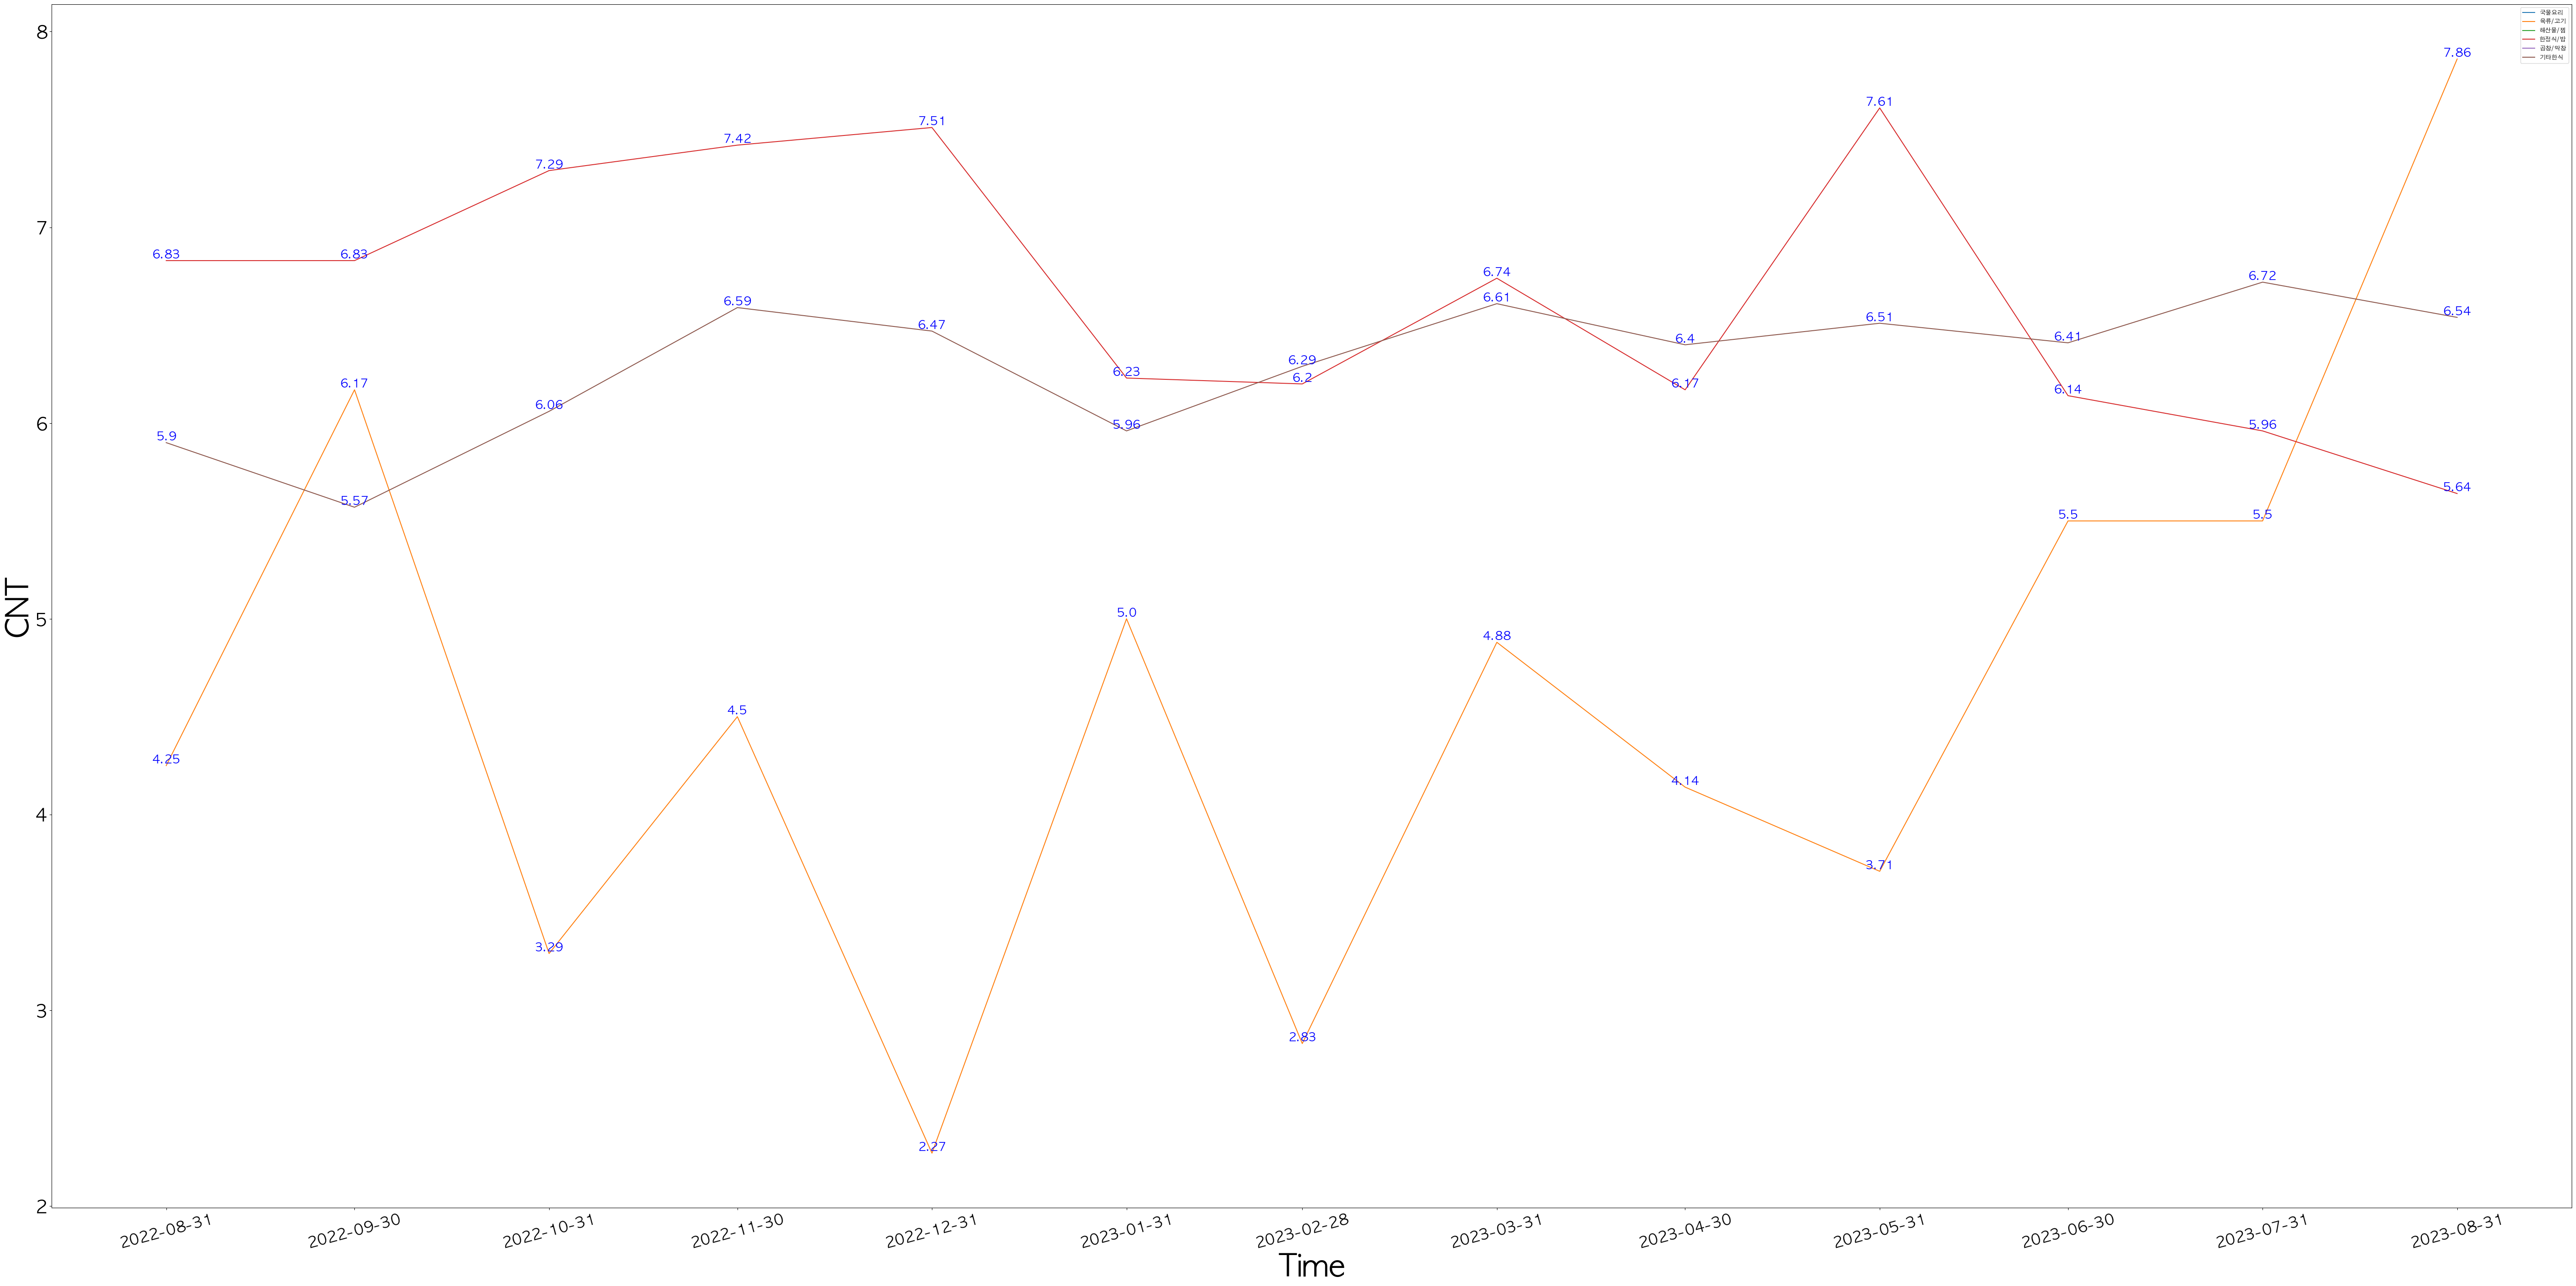

CPU times: user 5.17 s, sys: 195 ms, total: 5.36 s
Wall time: 4.79 s


In [62]:
%%time
selected_category = '한식'
resampling = 'M'
date_start = '2022-08'
date_end = '2023-08'

plt.figure(figsize = (60, 30)) # 전체 figure 크기

for food1 in category[selected_category]:
    temp_review = part_each_review[[x in food1 for x in part_each_review['category'].values]]
    temp_review['CNT']=1
    temp_review_w = temp_review.resample(resampling)['CNT'].agg(np.sum).fillna(0)
    temp_review_len = temp_review['obj_key'].resample(resampling).agg(np.unique).apply(lambda x: len(x) if len(x)>0 else 1)
    temp_review_average = np.round(temp_review_w / temp_review_len, 2)
    x = temp_review_average[date_start:date_end].index # x축(시간 정보)
    y = temp_review_average[date_start:date_end] # y축 값(데이터 개수)

    plt.plot(x,y, label=food1) # 그래프 시각화

    # 값 시각화
    for i, v in enumerate(x):
        plt.text(v, y[i], y[i],
                 fontsize = 20, 
                 color = 'blue',
                 horizontalalignment ='center',
                 verticalalignment = 'bottom')
plt.xticks(x, fontsize = 25, rotation = 15) # x축
plt.yticks(fontsize = 30) # y축 눈금
plt.xlabel('Time', fontsize = 50) # x축 이름
plt.ylabel('CNT', fontsize = 50) # y축 이름
plt.legend()
plt.tight_layout()
plt.show()